## Введение

Семинарскую часть ноутбука стоит выполнить, а в последующих заданиях пользоваться полученными результатми семинара как стартовой точкой. Семинарская часть заблокирована от изменений. Это сделано для того, чтобы вы случайно не потеряли ее. Однако, при желании, вы можете создавать новые ячейки и вставлять туда код со своими изменениями, чтобы разобраться. Удачи!

## Семинарская часть

Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Данные уже скачаны.

Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')

In [2]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [3]:
df = df.drop('dropoff_datetime', axis=1)

Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [4]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [5]:
df = df.sort_values(by='pickup_datetime')

In [6]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [7]:
df_train = df[:500_000]
df_test = df[500_000:700_000]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на целевую переменную.

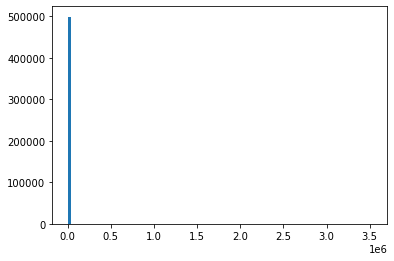

In [8]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

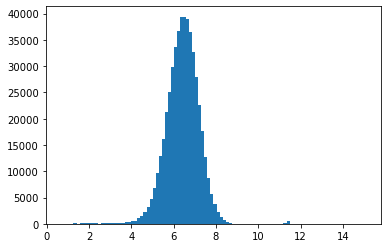

In [9]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [10]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

<ipython-input-10-05311ce01512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
<ipython-input-10-05311ce01512>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


In [11]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

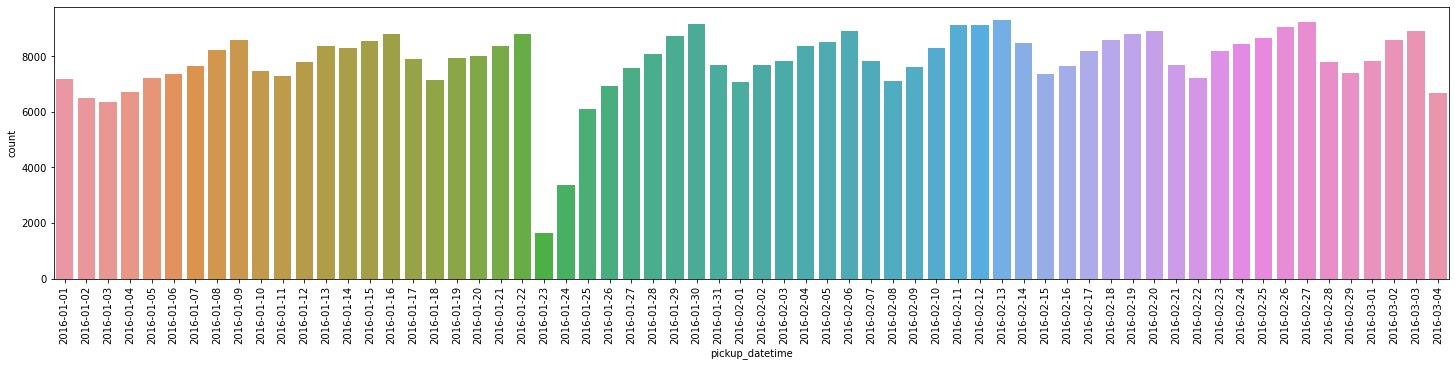

In [12]:
date_sorted = df_train.pickup_datetime.dt.date.sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

C:\Users\Alexey93\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


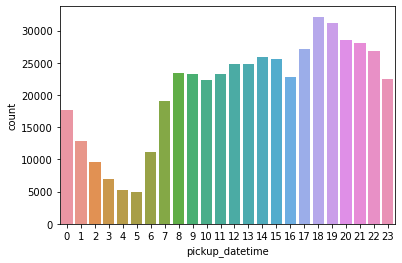

In [13]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

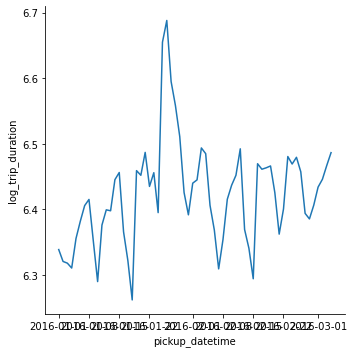

In [14]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.dt.date)
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [15]:
import datetime
def create_features(data_frame):
    X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
    )
  
    return X, data_frame.log_trip_duration

In [16]:
X_train, y_train = create_features(df_train)

In [17]:
X_test, y_test = create_features(df_test)

In [18]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [20]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [21]:
X_train = ohe.fit_transform(X_train)

In [22]:
X_test = ohe.transform(X_test)

Воспользуемся классом `Ridge` и обучим модель.

In [23]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [24]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [25]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6182271895783967

## Часть для самостоятельного выполнения:

### Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. Какой из этих графиков соответствует правильному?


1)
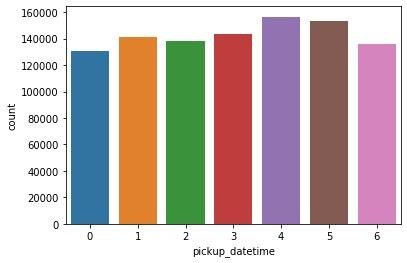

2)
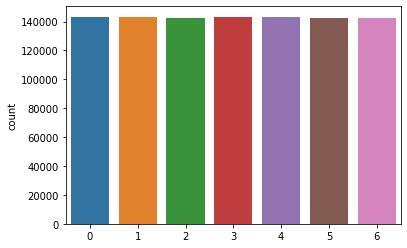

3)
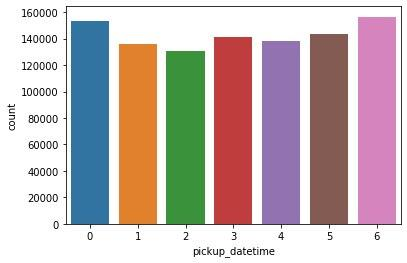

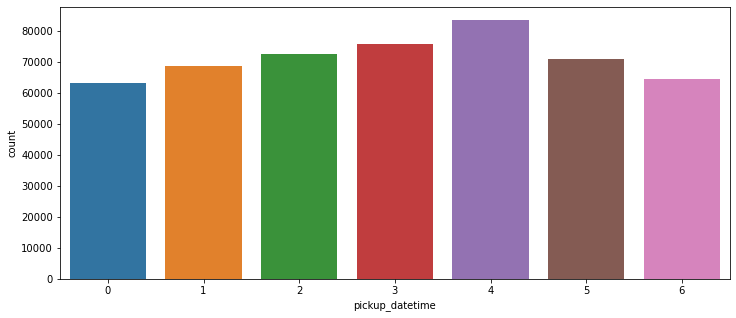

In [26]:
date_weekday = df_train.pickup_datetime.apply(lambda x: x.weekday())
plt.figure(figsize=(12, 5))
date_count_plot = sns.countplot(x=date_weekday,)

correct_graph = 1

In [27]:
# проверка, просто запустите ячейку


### Задание 2

Добавьте к признакам one-hot переменную, которая равна 1 (или True) для двух аномальных дней и 0 (или False) во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features. 

Рекомендуется создавать новые датафреймы из стартовых для домашнего задания (то есть df_train и df_test). На выходе из функции вы должны получить dataframe с 3 признаками: ```day```, ```hour``` и ```anomaly```. Подсказка: сделать это можно всего за 3 применения .apply(). Иначе ваша функция может работать слишком долго.

In [28]:
def create_features(data_frame):
    X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
      data_frame.pickup_datetime.apply(lambda x: 1 if (x.timetuple().tm_yday)==23 or (x.timetuple().tm_yday)==24 else 0),
     ], axis=1, keys=['day', 'hour','anomaly']
    )
  
    return X, data_frame.log_trip_duration

In [29]:
new_X_train, new_y_train = create_features(df_train)

Обратите внимание: для успешной сдачи, wall time должен быть < 30 секунд.
Когда убедитесь, что фукнция работает достаточно быстро, **удалите %time**. 

Далее идет небольшая неоцениваемая проверка. Понимать код написанный там не нужно. Просто запустите ячейку. Если она запускается без ошибок - можете продолжать, иначе - следуйте в соответствии с выданной ошибкой (предварительно раскомментируйте)

In [30]:
# Небольшая проверка: если ячейка выполнилась без ошибок, можете продолжать.

assert 'new_X_train' in locals(), "Переменной new_X_train не существует. Проверьте названия."
assert 'new_y_train' in locals(), "Переменной new_y_train не существует. Проверьте названия."
assert type(new_X_train) == pd.core.frame.DataFrame, \
                            "Переменная new_X_train должна быть типа pandas DataFrame"
assert len(new_X_train) == 500_000, "Количество примеров должно остаться равным 500 000"
assert all(new_X_train.columns.values == ['day', 'hour', 'anomaly']), \
                            "Проверьте количество и названия колонок"
assert all(new_X_train[new_X_train['day'] == 24]['anomaly'] == True), \
                            "Значение признака anomaly для сэмплов 24.01 должно равняться True или 1"
assert any(new_X_train[(new_X_train['day'] != 23) & (new_X_train['day'] != 24)]['anomaly']) == False, \
                            "Значение признака anomaly для сэмплов не 23.01 и 24.01 должно равняться False или 0"

In [31]:
# Если предыдущая ячейка не выдала ошибок, можно смело выполнять для теста:

new_X_test, new_y_test = create_features(df_test)

In [32]:
# А теперь полноценная проверка переменных new_X_train, new_X_test
# Просто запустите ячейку


# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.  Рекомендуется создавать новые датафреймы из стартовых для домашнего задания (то есть df_train и df_test). Соответственно, у вас должен добавиться один вызов .apply() относительно задания 2. 

2. Заново проведите one-hot кодирование (для **небинарных, категориальных** признаков). Сколько признаков у вас получилось?

In [33]:
def create_features(data_frame):
    X = pd.concat([
    data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
    data_frame.pickup_datetime.apply(lambda x: x.hour),
    data_frame.pickup_datetime.apply(lambda x: 1 if (x.timetuple().tm_yday)==23 or (x.timetuple().tm_yday)==24 else 0),
    data_frame.pickup_datetime.apply(lambda x: x.weekday()),   
     ], axis=1, keys=['day', 'hour','anomaly','weekday']
    )
  
    return X, data_frame.log_trip_duration

In [34]:
new_X_train, new_y_train = create_features(df_train)

Когда убедитесь, что фукнция работает достаточно быстро, **удалите %time** и выполняйте для теста:

In [35]:
new_X_test, new_y_test = create_features(df_test)

Теперь проведите OHE и запишите количество полученных признаков в переменную ```num_features```:

In [36]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1,3])], remainder="passthrough")
new_X_train = ohe.fit_transform(new_X_train)
new_X_test= ohe.transform(new_X_test)
num_features = new_X_train.shape[1]

In [37]:
# Небольшая проверка для себя
# В таких блоках мы сравниваем хэш вашего ответа и верного. 
# Таким образом вы поймете, правильный ли ваш ответ на данное задание

# Если ничего не вывелось, то ответ верный. Если ошибка, то проверьте это задание.
import hashlib

assert hashlib.sha256(str(num_features).encode()).hexdigest() == 'c6f3ac57944a531490cd39902d0f777715fd005efac9a30622d5f5205e7f6894'

In [38]:
# В этой ячейке проверится итоговое количество признаков; переменная num_features
# проверка, просто запустите ячейку


# Задание 4.1

Продолжим работать с полученными в предыдущем задании пременными. На данный момент мы создали один вещественный и несколько категориальных признаков. После этого мы воспользовались OHE преобразованием для небинарных категориальных признаков. Пришло время обработать вещественный признак и, все-таки, обучить модель. Для этого продолжайте работать с полученными в предыдущем задании DataFrame для обучающего и тестового датасетов:

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра `alpha` возьмите 2.65e-05.

Какое качество (на тестовых данных) в терминах MSE вы получили?

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transform = ColumnTransformer([('St Sc', StandardScaler(), [31])], remainder="passthrough")
new_X_train = transform.fit_transform(new_X_train)
new_X_test = transform.fit_transform(new_X_test)

Чтобы не тратить время и мощности мы отрежем только 10000 примеров от обучающих данных. Здесь будет проверяться ответ именно для модели, обученной на первых 10000 примерах. Округлите значение **до 3 знаков** после запятой.

Вы можете выполнить данный ноутбук в локальном jupyter или где-то еще и обучить модель на всем наборе данных. Абсолютно весь код при этом будет таким же, но на время обучения модели может потребоваться некоторое время.

In [40]:
X_train = new_X_train[:10_000, :]  # если ваш датафрейм назвается по-другому замените название переменной
y_train = new_y_train[:10_000]     # если ваши датафреймы назваются по-другому замените название переменной

X_test = new_X_test[:2_500, :]
y_test = new_y_test[:2_500]

In [41]:
# Ваш код для обучения Lasso регрессии с параметром alpha 2.65e-05 и подсчетом MSE:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=2.65e-05).fit(X_train, y_train)
MSE = round(mean_squared_error(lasso.predict(X_test), y_test),3)

In [42]:
# Небольшая проверка для себя
import hashlib

assert hashlib.sha256(str(round(MSE, 3)).encode()).hexdigest() == '7a7aaf305bb9f734cf66fb258decc961e20739efac706ef440a4f5f2a2afd5b2'

AssertionError: 

In [43]:
# проверка, просто запустите ячейку


# Задание 4.2

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$.

In [44]:
num_nonzero_features = len([i for i in lasso.coef_ if i >= 10 ** (-6)])

In [45]:
# Небольшая проверка для себя
import hashlib

assert hashlib.sha256(str(num_nonzero_features).encode()).hexdigest() == '3fdba35f04dc8c462986c992bcf875546257113072a909c162f7e470e581e278'

In [46]:
# проверка, просто запустите ячейку
